# 1. Getting Data

First we will get some data using sklearn, and push it into a pandas dataframe.  Note this step is for convenience only, a "real" use case would se data that was in S3, Snowflake etc.



In [26]:
from nltk.corpus import stopwords
import pandas as pd
import nltk
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import unicodedata
import seaborn as sns

from snowflake.snowpark.session import Session
from snowflake.snowpark.functions import sproc
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T

In [27]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.sys.ibm.pc.hardware',  'comp.sys.mac.hardware', 'comp.windows.x']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

newsgroups_test = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

train_df = pd.DataFrame()
train_df["TEXT"] = newsgroups_train.data
train_df['Y'] = newsgroups_train.target

test_df = pd.DataFrame()
test_df["TEXT"] = newsgroups_test.data
test_df['Y'] = newsgroups_test.target

# 2. Load Data into Snowflake

The credentials json should look like this:
    
    {
    "account": "your_account_name", 
    "user": "your_user_name",
    "password": "insert_your_pwd_here",
    "role": "ACCOUNTADMIN"
}

In [3]:
snowflake_connection_cfg = json.loads(open("/Users/mitaylor/Documents/creds/creds.json").read())
session = Session.builder.configs(snowflake_connection_cfg).create()
session.sql("CREATE OR REPLACE WAREHOUSE CD_VH WITH WAREHOUSE_SIZE='X-SMALL'").collect()
#session.sql("USE DATABASE CD_DB").collect()

session.sql("CREATE OR REPLACE DATABASE CD_DB").collect()
session.sql("CREATE OR REPLACE STAGE CD_STAGE").collect()

[Row(status='Statement executed successfully.')]

In [4]:
session.write_pandas(train_df, table_name='TRAIN_DF', auto_create_table=True, overwrite=True)
session.write_pandas(test_df, table_name='TEST_DF', auto_create_table=True, overwrite=True)

# 2. Start NLPing!

## 2.LOC The Local Approach

### 2.LOC.1 Stopwords

In [5]:
nltk.download('stopwords')
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mitaylor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def simplify(text):
    try:
        text = unicode(text, "utf-8")
    except NameError:
        pass
    text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("utf-8")
    return str(text)

stopwords = [simplify(d) for d in stopwords]

### 2.LOC.2 TFIDF Processing

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    min_df=1,
    max_features=None,
    strip_accents="unicode",
    analyzer="word",
    token_pattern=r"[a-zA-Z0-9]{1,}",
    ngram_range=(1, 3),
    use_idf=1,
    smooth_idf=1,
    sublinear_tf=1,
    stop_words=stopwords,
)
train_tfidf = vectorizer.fit_transform(train_df["TEXT"])

test_tfidf = vectorizer.transform(test_df["TEXT"])

/Users/mitaylor/opt/anaconda3/envs/xavier_test/lib/python3.9/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


### 2.LOC.3 Machine Learning

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics

model = LogisticRegression(penalty="l2", C=56.898, multi_class="ovr", verbose=0, n_jobs=15, max_iter=300)
print("Fit logistic regression...")
%time model.fit(train_tfidf, train_df["Y"])



Fit logistic regression...
CPU times: user 55.5 ms, sys: 273 ms, total: 328 ms
Wall time: 3.12 s


LogisticRegression(C=56.898, max_iter=300, multi_class='ovr', n_jobs=15)

### 2.LOC.4 Inference

In [9]:
pred = model.predict(test_tfidf)
metrics.f1_score(newsgroups_test.target, pred, average='macro')

0.8605030652969825

In [10]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(newsgroups_test.target, pred)
cm = cm/len(pred)
cm

array([[0.28498294, 0.03583618, 0.01365188],
       [0.04692833, 0.26706485, 0.01450512],
       [0.01279863, 0.01535836, 0.30887372]])

<Axes: >

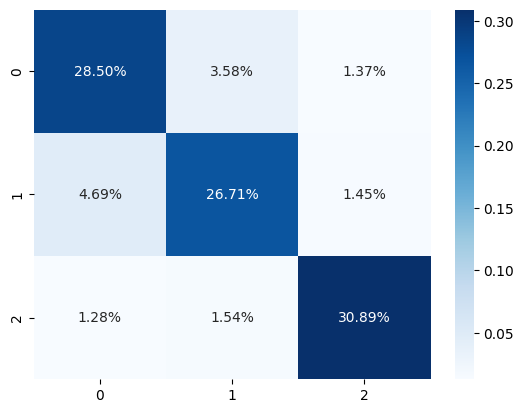

In [11]:
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')

## 2.SNOW The Snowflake Way

### 2.SNOW.1 Stopwords Test

In [13]:
@sproc(session=session, name='hello_world_test', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'regex', 'nltk'], 
       is_permanent=True, 
       replace=True)
def hello_world_test(session: Session) -> str:
    hello_world = 'hello world'
    return hello_world

The version of package 'regex' in the local environment is 2023.8.8, which does not fit the criteria for the requirement 'regex'. Your UDF might not work when the package version is different between the server and your local environment.


In [14]:
hello_world_test()

'hello world'

In [14]:
# Now try and create your own Sproc that returns the stop words







### 2.SNOW.1 Stopwords Solution

In [15]:
# Solution
@sproc(session=session, name='get_stopwords_v1', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'regex', 'nltk'], 
       is_permanent=True, 
       replace=True)
def sproc_test_stopwords_v1(session: Session) -> list:
    import nltk
    nltk.download('stopwords')
    stopwords = nltk.corpus.stopwords.words("english")
    return stopwords


The version of package 'regex' in the local environment is 2023.8.8, which does not fit the criteria for the requirement 'regex'. Your UDF might not work when the package version is different between the server and your local environment.


In [16]:
sproc_test_stopwords_v1()

SnowparkSQLException: (1304): 01aeef15-0000-90a4-0000-f149003df012: 100357 (P0000): Python Interpreter Error:
Traceback (most recent call last):
  File "/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/python3.9/site-packages/nltk/corpus/util.py", line 84, in __load
    root = nltk.data.find(f"{self.subdir}/{zip_name}")
  File "/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/python3.9/site-packages/nltk/data.py", line 583, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords.zip/stopwords/[0m

  Searched in:
    - '/home/udf/nltk_data'
    - '/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/nltk_data'
    - '/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/share/nltk_data'
    - '/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "_udf_code.py", line 19, in compute
  File "/var/folders/97/8vc6xcbx4zd06p75xg9frdrw0000gn/T/ipykernel_23661/2598087368.py", line 9, in sproc_test_stopwords_v1
  File "/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/python3.9/site-packages/nltk/corpus/util.py", line 121, in __getattr__
    self.__load()
  File "/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/python3.9/site-packages/nltk/corpus/util.py", line 86, in __load
    raise e
  File "/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/python3.9/site-packages/nltk/corpus/util.py", line 81, in __load
    root = nltk.data.find(f"{self.subdir}/{self.__name}")
  File "/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/python3.9/site-packages/nltk/data.py", line 583, in find
    raise LookupError(resource_not_found)
LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/stopwords[0m

  Searched in:
    - '/home/udf/nltk_data'
    - '/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/nltk_data'
    - '/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/share/nltk_data'
    - '/usr/lib/python_udf/7b1e9c1de04786808c181f8047dc965cc86b29c4c67f6d3ffa840e844504720a/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************

 in function GET_STOPWORDS_V1 with handler compute

#### 2.SNOW.1 Additional

Uh oh, what happened?  Let's make sure Snowflake supports NLTK:

https://repo.anaconda.com/pkgs/snowflake/

It's there, so what's the problem? Well, Snowflake is serious about security and allows very little external access, especially access that is performed by an app.  But we need to get our stopwords in....

We need to load this data in ourselves

In [15]:
session.sql('''PUT file:///Users/mitaylor/nltk_data/corpora/stopwords.zip @CD_STAGE/nltk_data/corpora;''').collect()

[Row(source='stopwords.zip', target='stopwords.zip.gz', source_size=34276, target_size=0, source_compression='NONE', target_compression='GZIP', status='SKIPPED', message='')]

In [16]:
pd.DataFrame(session.sql('LS @CD_STAGE').collect())

,name,size,md5,last_modified
0,cd_stage/PIPE_MODEL.sav,17812608,710421132e58a0516a861e888ac54a09,"Tue, 12 Sep 2023 07:12:09 GMT"
1,cd_stage/PIPE_MODEL_SPROC.sav,17812608,d35c8f63e68bcf6b07a05f3cadf52319,"Tue, 12 Sep 2023 07:11:55 GMT"
2,cd_stage/ec1167d39b388d2f9a47e57dd2e9b07810696...,14304,46340bde5d50f60ae16e3197393cb294,"Mon, 11 Sep 2023 09:01:21 GMT"
3,cd_stage/lr_model.sav,6842112,d28f6a080320ecdcb2b5d238fa4f72d7,"Tue, 12 Sep 2023 06:48:33 GMT"
4,cd_stage/nltk_data/corpora/stopwords.zip.gz,31088,06cafc67e71e2c2fed97d2519f9e7b2f,"Mon, 11 Sep 2023 08:51:38 GMT"
5,cd_stage/vectoriser,10970624,f9ff3a975cc78ac4986fd0a3e4dd7cc0,"Mon, 11 Sep 2023 09:14:24 GMT"
6,cd_stage/vectoriser.sav,10970624,30261644ded1395737c211f245057311,"Tue, 12 Sep 2023 06:47:53 GMT"


and use shutil to help us create the right structures in Snowflake

In [17]:
import shutil
shutil

<module 'shutil' from '/Users/mitaylor/opt/anaconda3/envs/xavier_test/lib/python3.9/shutil.py'>

In [18]:
# Register sproc
@sproc(session=session, name='get_stopwords_v1', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'regex', 'nltk'], 
       is_permanent=True, 
       replace=True,
       imports=['@CD_STAGE/nltk_data/corpora/stopwords.zip', '/Users/mitaylor/opt/anaconda3/envs/xavier_test/lib/python3.9/shutil.py'])
def sproc_test_stopwords_v1(session: Session) -> list:
    import nltk
    import os
    import shutil
    import sys

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    # set up nltk data asset directory
    nltk.data.path.append(import_dir)
    data_path = '/tmp/nltk_data/'
    nltk.data.path.append(data_path)
    os.environ["NLTK_DATA"] = data_path

    # copy data for wordnet
    os.makedirs(os.path.join(data_path, 'corpora'), exist_ok=True)
    shutil.copy(os.path.join(import_dir, 'stopwords.zip'), os.path.join(data_path, 'corpora/stopwords.zip'))

    # import the lexicon file
    lex_file = os.path.join(import_dir, 'nrc_en.json')

    return nltk.corpus.stopwords.words("english")

The version of package 'regex' in the local environment is 2023.8.8, which does not fit the criteria for the requirement 'regex'. Your UDF might not work when the package version is different between the server and your local environment.


In [19]:
sproc_test_stopwords_v1()

'[\n  "i",\n  "me",\n  "my",\n  "myself",\n  "we",\n  "our",\n  "ours",\n  "ourselves",\n  "you",\n  "you\'re",\n  "you\'ve",\n  "you\'ll",\n  "you\'d",\n  "your",\n  "yours",\n  "yourself",\n  "yourselves",\n  "he",\n  "him",\n  "his",\n  "himself",\n  "she",\n  "she\'s",\n  "her",\n  "hers",\n  "herself",\n  "it",\n  "it\'s",\n  "its",\n  "itself",\n  "they",\n  "them",\n  "their",\n  "theirs",\n  "themselves",\n  "what",\n  "which",\n  "who",\n  "whom",\n  "this",\n  "that",\n  "that\'ll",\n  "these",\n  "those",\n  "am",\n  "is",\n  "are",\n  "was",\n  "were",\n  "be",\n  "been",\n  "being",\n  "have",\n  "has",\n  "had",\n  "having",\n  "do",\n  "does",\n  "did",\n  "doing",\n  "a",\n  "an",\n  "the",\n  "and",\n  "but",\n  "if",\n  "or",\n  "because",\n  "as",\n  "until",\n  "while",\n  "of",\n  "at",\n  "by",\n  "for",\n  "with",\n  "about",\n  "against",\n  "between",\n  "into",\n  "through",\n  "during",\n  "before",\n  "after",\n  "above",\n  "below",\n  "to",\n  "from",\n  "

Alternatively, we could always just load this list in to a table, but this tutorial was designed to enable full use of NLTK.

### 2.SNOW.2 TFIDF Processing Test

In [ ]:
@sproc(session=session, name='TFIDF_FIT', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'scikit-learn', 'regex', 'nltk'], 
       is_permanent=True, 
       replace=True,
      )
def tfidf_train_proc(session: Session, target_table: str, model_name: str) -> str:
    from sklearn.feature_extraction.text import TfidfVectorizer
    import nltk
    import os
    import shutil
    import sys
    from joblib import dump
    
    def simplify(text):
        try:
            text = unicode(text, "utf-8")
        except NameError:
            pass
        text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("utf-8")
        return str(text)    

    
    
    ############################################################################################################################################
    
    
    
    train_df = # need to get your data into a pandas dataframe, hint to_pandas()
    # then train your vectoriser
    
    
    ############################################################################################################################################

    dump(vectorizer_model, '/tmp/'+model_name)
    session.file.put('/tmp/'+model_name, '@CD_STAGE', auto_compress=False, overwrite=True)
    
    return "vectoriser trained"                

In [ ]:
tfidf_train_proc("TRAIN_DF", "vectoriser.sav")

### 2.SNOW.2 TFIDF Processing Solution

In [20]:
@sproc(session=session, name='TFIDF_FIT', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'scikit-learn', 'regex', 'nltk'], 
       is_permanent=True, 
       replace=True,
      )
def tfidf_train_proc(session: Session, target_table: str, model_name: str) -> str:
    from sklearn.feature_extraction.text import TfidfVectorizer
    import nltk
    import os
    import shutil
    import sys
    from joblib import dump    
    
    train_df = session.table("TRAIN_DF").to_pandas()
                
    vectorizer = TfidfVectorizer(
        min_df=1,
        max_features=None,
        strip_accents="unicode",
        analyzer="word",
        token_pattern=r"[a-zA-Z0-9]{1,}",
        ngram_range=(1, 3),
        use_idf=1,
        smooth_idf=1,
        sublinear_tf=1,
    )
    vectorizer_model = vectorizer.fit(train_df["TEXT"])

    dump(vectorizer_model, '/tmp/'+model_name)
    session.file.put('/tmp/'+model_name, '@CD_STAGE', auto_compress=False, overwrite=True)
    
    return "vectoriser trained"
                
    
                

The version of package 'regex' in the local environment is 2023.8.8, which does not fit the criteria for the requirement 'regex'. Your UDF might not work when the package version is different between the server and your local environment.


In [21]:
tfidf_train_proc("TRAIN_DF", "vectoriser.sav")

'vectoriser trained'

### 2.SNOW.3 Machine Learning Test

In [32]:
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model
   
@sproc(session=session, name='TFIDF_FIT', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'scikit-learn', 'joblib','cachetools'], 
       is_permanent=True, 
       replace=True,
       imports=[] # <- what imports do you need to make this work, hint in the vectoriser line in the main sproc
      )
def ml_train_sproc(session: Session) -> str: # what else other than Session (which you need for everything do you need to pass as a call (hint vectoriser, table name and one other)
    from sklearn.linear_model import LogisticRegression
    from joblib import dump
    import sys
    import numpy as np
    
    vectoriser = load_model(sys._xoptions["snowflake_import_directory"]+vectoriser_name)
    train_df = session.table(train_table).to_pandas()
    X = vectoriser.transform(train_df['TEXT'])
    y = np.array(train_df['Y'])
    
    ############################################################################################################################################
    
    # Train a model (lrmodel) here, should be just like you do in regular python
    
    ############################################################################################################################################
    
    dump(lrmodel, '/tmp/'+ml_model_name)
    session.file.put('/tmp/'+ml_model_name, '@CD_STAGE', auto_compress=False, overwrite=True)
    return('ML Model trained and saved')

In [33]:
ml_train_sproc(some arguments)

'ML Model trained and saved'

### 2.SNOW.3 Machine Learning Solution

In [22]:
from cachetools import cached

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model
   
@sproc(session=session, name='TFIDF_FIT', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'scikit-learn', 'joblib','cachetools'], 
       is_permanent=True, 
       replace=True,
       imports=['@CD_STAGE/vectoriser.sav']
      )
def ml_train_sproc(session: Session, train_table:str, vectoriser_name: str, ml_model_name: str) -> str:
    from sklearn.linear_model import LogisticRegression
    from joblib import dump
    import sys
    import numpy as np
    
    vectoriser = load_model(sys._xoptions["snowflake_import_directory"]+vectoriser_name)
    train_df = session.table(train_table).to_pandas()
    X = vectoriser.transform(train_df['TEXT'])
    y = np.array(train_df['Y'])
    lrmodel = LogisticRegression().fit(X, y)
    dump(lrmodel, '/tmp/'+ml_model_name)
    session.file.put('/tmp/'+ml_model_name, '@CD_STAGE', auto_compress=False, overwrite=True)
    return('ML Model trained and saved')

In [23]:
ml_train_sproc("TRAIN_DF", "vectoriser.sav", 'lr_model.sav')

'ML Model trained and saved'

### 2.SNOW.4 Inference Test

In [84]:
from snowflake.snowpark.types import PandasDataFrameType, IntegerType, StringType, FloatType

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

class ml_predict:
    """
    ML_Tree Search which takes in a given dataset and calculates the score for each unique dataset

    """
    def __init__(self):
        import sys
        
        ############################################################################################################################################
        
        self.vectoriser = # need to load your vectoriser here
        self.clf = # need to load your ml model here here
        
        ############################################################################################################################################

        
    def end_partition(self, df):
        
        text = df.iloc[:,0]
        y_true = df.iloc[:,1]
        
        ############################################################################################################################################
        
        # use your vectoriser here
        # use your ml model to predict here
        
        ############################################################################################################################################

        df_new = pd.DataFrame()
        
        df_new['Y_TRUE_'] = y_true
        df_new['Y_PRED_'] = y_pred
        yield df_new

ml_predict.end_partition._sf_vectorized_input = pd.DataFrame

ml_predict = session.udtf.register(
    ml_predict, # the class
    input_types=[PandasDataFrameType([StringType()] + # TEXT
                                 [IntegerType()] # Y
                                )], # 
    output_schema=PandasDataFrameType([IntegerType(), IntegerType()], ["Y_TRUE_", "Y_PRED_"]),
    packages=["snowflake-snowpark-python", 'scikit-learn==1.1.1', 'numpy', 'pandas', 'cachetools'],
    imports=['@CD_STAGE/lr_model.sav', '@CD_STAGE/vectoriser.sav'],
    stage_location='@CD_STAGE')   

In [86]:
sdf_tmp = session.table('TEST_DF')
all_cols = sdf_tmp.columns
pdf_res = sdf_tmp.select(ml_predict(*all_cols).over(partition_by=['Y'])) # your missing a .something() at the end of this to turn a snowpark dataframe into a pandas dataframe
pdf_res

,Y_TRUE_,Y_PRED_
0,1,1
1,1,2
2,1,2
3,1,1
4,1,1
...,...,...
1167,2,2
1168,2,2
1169,2,2
1170,2,2


### 2.SNOW.4 Inference Solution

In [26]:
from snowflake.snowpark.types import PandasDataFrameType, IntegerType, StringType, FloatType

@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

class ml_predict:
    """
    ML_Tree Search which takes in a given dataset and calculates the score for each unique dataset

    """
    def __init__(self):
        import sys
        self.vectoriser = load_model(sys._xoptions["snowflake_import_directory"]+'vectoriser.sav')
        self.clf = load_model(sys._xoptions["snowflake_import_directory"]+'lr_model.sav')

        
    def end_partition(self, df):
        
        text = df.iloc[:,0]
        y_true = df.iloc[:,1]
        tfidf = self.vectoriser.transform(text)
        y_pred = self.clf.predict(tfidf)
        df_new = pd.DataFrame()
        
        df_new['Y_TRUE_'] = y_true
        df_new['Y_PRED_'] = y_pred
        yield df_new

ml_predict.end_partition._sf_vectorized_input = pd.DataFrame

ml_predict = session.udtf.register(
    ml_predict, # the class
    input_types=[PandasDataFrameType([StringType()] + # TEXT
                                 [IntegerType()] # Y
                                )], # 
    output_schema=PandasDataFrameType([IntegerType(), IntegerType()], ["Y_TRUE_", "Y_PRED_"]),
    packages=["snowflake-snowpark-python", 'scikit-learn==1.1.1', 'numpy', 'pandas', 'cachetools'],
    imports=['@CD_STAGE/lr_model.sav', '@CD_STAGE/vectoriser.sav'],
    stage_location='@CD_STAGE')   

In [28]:
sdf_tmp = session.table('TEST_DF')
all_cols = sdf_tmp.columns
pdf_res = sdf_tmp.select(ml_predict(*all_cols).over(partition_by=['Y'])).to_pandas()
pdf_res

,Y_TRUE_,Y_PRED_
0,1,1
1,1,2
2,1,2
3,1,1
4,1,1
...,...,...
1167,2,2
1168,2,2
1169,2,2
1170,2,2


### 2.SNOW.5 Putting it all together!

In [29]:
cm = confusion_matrix(list(pdf_res.Y_TRUE_), list(pdf_res.Y_PRED_))
cm = cm/len(pred)
cm

array([[0.28498294, 0.03668942, 0.01279863],
       [0.05204778, 0.26706485, 0.00938567],
       [0.01194539, 0.01279863, 0.31228669]])

<Axes: >

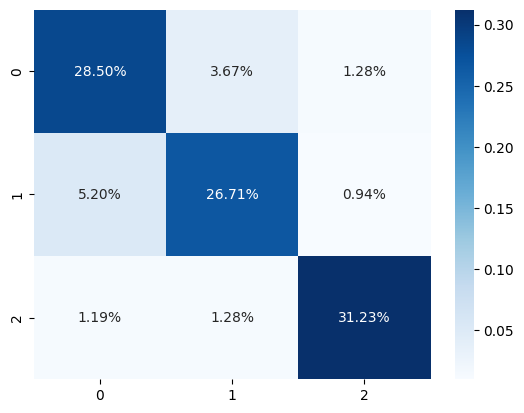

In [30]:
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues')

### 2.SNOW.6 Bonus - Making it a single pipeline

In [38]:
@sproc(session=session, name='PIPELINE', stage_location='@CD_STAGE',  
       packages=['snowflake-snowpark-python', 'scikit-learn', 'regex', 'nltk'], 
       is_permanent=True, 
       replace=True,
        imports=['@CD_STAGE/nltk_data/corpora/stopwords.zip', '/Users/mitaylor/opt/anaconda3/envs/xavier_test/lib/python3.9/shutil.py']
      )
def pipeline_sproc(session: Session, train_table: str, model_name: str) -> str:
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.pipeline import Pipeline
    from sklearn.linear_model import LogisticRegression
    
    import nltk
    import os
    import shutil
    import sys
    from joblib import dump
    
    def simplify(text):
        try:
            text = unicode(text, "utf-8")
        except NameError:
            pass
        text = unicodedata.normalize("NFD", text).encode("ascii", "ignore").decode("utf-8")
        return str(text)    

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    # set up nltk data asset directory
    nltk.data.path.append(import_dir)
    data_path = '/tmp/nltk_data/'
    nltk.data.path.append(data_path)
    os.environ["NLTK_DATA"] = data_path

    # copy data for wordnet
    os.makedirs(os.path.join(data_path, 'corpora'), exist_ok=True)
    shutil.copy(os.path.join(import_dir, 'stopwords.zip'), os.path.join(data_path, 'corpora/stopwords.zip'))

    stopwords = nltk.corpus.stopwords.words("english")
    stopwords = [simplify(d) for d in stopwords]
    
    data = session.table(train_table).to_pandas()
    y_train = data['Y']
    X_train = data['TEXT']
    
    vectorizer = TfidfVectorizer(
        min_df=1,
        max_features=None,
        strip_accents="unicode",
        analyzer="word",
        token_pattern=r"[a-zA-Z0-9]{1,}",
        ngram_range=(1, 3),
        use_idf=1,
        smooth_idf=1,
        sublinear_tf=1,
        stop_words=stopwords,
    )

    # Build a pipeline
    pipe = Pipeline([('vectoriser', vectorizer),
                   ('LR', LogisticRegression())])
    pipe.fit(X_train, y_train)
    dump(pipe, '/tmp/'+model_name)
    session.file.put('/tmp/'+model_name, '@CD_STAGE', auto_compress=False, overwrite=True)

The version of package 'regex' in the local environment is 2023.8.8, which does not fit the criteria for the requirement 'regex'. Your UDF might not work when the package version is different between the server and your local environment.


In [40]:
# Let's Run Our Sproc (and save the model result)
pipeline_sproc('TRAIN_DF', 'PIPE_MODEL.sav')
print('ML Model trained and saved')

ML Model trained and saved


In [61]:
# Register the pipeline as a UDF
@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

def udf_pipe_model(df: pd.DataFrame) -> pd.Series:
    import pandas as pd
    import sys
    model = load_model(sys._xoptions["snowflake_import_directory"]+'PIPE_MODEL.sav')
    
    scored_data = pd.Series(model.predict(df.iloc[:,0]))
    return scored_data

feature_cols = ["TEXT"]
udf_pipe_model = session.udf.register(session=session,func=udf_pipe_model,
                                 name="udf_score_pipe_model",
                                 stage_location='@CD_STAGE',
                                 input_types=[T.StringType()]*len(feature_cols),
                                 return_type=T.FloatType(),
                                 replace=True, is_permanent=True,
                                 max_batch_size=1000,
                                 imports=['@CD_STAGE/PIPE_MODEL.sav'],
                                 packages=['scikit-learn', 'nltk', 'pandas','regex','joblib','cachetools'])

The version of package 'regex' in the local environment is 2023.8.8, which does not fit the criteria for the requirement 'regex'. Your UDF might not work when the package version is different between the server and your local environment.


In [66]:
%%time
test_sdf = session.table('TEST_DF')
test_res = test_sdf.with_column('Y_PRED', udf_pipe_model(['TEXT']))
print(test_res.limit(15).to_pandas())

                                                 TEXT  Y  Y_PRED
0   Greetings,\n  I need some help with the detail...  2     2.0
1   I'm running HP-UX 8.07 with HP VUE 2.01 and I ...  2     2.0
2   Here's another question by a hesitant Powerboo...  1     1.0
3   I'm trying to connect a Mac SE modem port to a...  0     1.0
4   \nI don't see this as a problem with the chip-...  0     0.0
5   Hi all netters,\n\n  If I upgrade my XT with a...  0     0.0
6   I'm trying to turn on Xauthorization using MIT...  2     2.0
7   Can anybody tell me anything about the availib...  2     2.0
8   \nI have two SCSI hard drives, each has 512KB ...  0     0.0
9   This discussion on viewing .ps files undex X11...  2     2.0
10  Someone mentioned a while ago that the Duos we...  1     1.0
11  \nYou may have been emailed this, but the IIsi...  1     1.0
12  I bought a 386DX-40 motherboard for 50$... no ...  0     0.0
13  2-The-Max VESA VL video controller/ Cirus Logi...  0     0.0
14  \n\tSeveral ways are 

### 2.SNOW.7 Bonus - Scaling Up

In [67]:
multiple = 150
dataset_name = "TEST_DF_" + str(multiple) + "X"
session.sql("CREATE OR REPLACE WAREHOUSE VB_VH WITH WAREHOUSE_SIZE='X-LARGE'").collect()
for i in range(0,150):
    test_sdf.write.save_as_table(dataset_name, mode="append", table_type="temporary")
sdf_big = session.table(dataset_name)


In [68]:
%%time
test_res = sdf_big.with_column('Y_PRED', udf_pipe_model(['TEXT']))
print(test_res.limit(15).to_pandas())

                                                 TEXT  Y  Y_PRED
0   Greetings,\n  I need some help with the detail...  2     2.0
1   I'm running HP-UX 8.07 with HP VUE 2.01 and I ...  2     2.0
2   Here's another question by a hesitant Powerboo...  1     1.0
3   I'm trying to connect a Mac SE modem port to a...  0     1.0
4   \nI don't see this as a problem with the chip-...  0     0.0
5   Hi all netters,\n\n  If I upgrade my XT with a...  0     0.0
6   I'm trying to turn on Xauthorization using MIT...  2     2.0
7   Can anybody tell me anything about the availib...  2     2.0
8   \nI have two SCSI hard drives, each has 512KB ...  0     0.0
9   This discussion on viewing .ps files undex X11...  2     2.0
10  Someone mentioned a while ago that the Duos we...  1     1.0
11  \nYou may have been emailed this, but the IIsi...  1     1.0
12  I bought a 386DX-40 motherboard for 50$... no ...  0     0.0
13  2-The-Max VESA VL video controller/ Cirus Logi...  0     0.0
14  \n\tSeveral ways are 